In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates
import  fitsio 

import  healpy 
import  requests
import  pandas                      as      pd
import  pylab                       as      pl
import  numpy                       as      np
import  matplotlib.pyplot           as      plt
import  astropy.io.fits             as      fits
import  skyfactor_v2
import  skyfactor_v3

from    astropy.table               import  Table, join, vstack, unique
from    astropy.coordinates         import  SkyCoord
from    astropy                     import  units as u
from    desitarget.cmx              import  cmx_targetmask
from    desitarget.targets          import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation      import  resample_flux
from    desispec.resolution         import  Resolution
from    desispec.specscore          import  compute_frame_scores
from    collections                 import  OrderedDict
from    mpl_toolkits.axes_grid1     import  make_axes_locatable
from    itertools                   import  combinations
from    desisurvey.utils            import  get_date
from    PIL                         import  Image
from    io                          import  BytesIO
from    desitarget.sv1              import  sv1_cuts 
from    desiutil                    import  dust

In [5]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

In [6]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0) + 0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    
    return  mag

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

In [7]:
GAMA  = {} 
LGAMA = {}

for hsphere in ['north', 'south']:
  try:  
    GAMA[hsphere]  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/{}/matched/GAMA-DR3-SpecObj-match.fits'.format(hsphere))
    LGAMA[hsphere] = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/{}/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits'.format(hsphere))  

  except:
    GAMA[hsphere]  = None
    LGAMA[hsphere] = None

In [8]:
SDSS  = {}
LSDSS = {}

for hsphere in ['north', 'south']:
  try: 
    SDSS[hsphere]  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/{}/matched/sdss-specObj-dr16-unique-trimmed-match.fits'.format(hsphere))
    LSDSS[hsphere] = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/{}/matched/ls-dr8.0-sdss-specObj-dr16-unique-trimmed-match.fits'.format(hsphere))
    
  except:
    SDSS[hsphere]  = None
    LSDSS[hsphere] = None

##  Truth table 

There are some caveats as Prospect behaviour changed midway, 
and it’s making it hard to combine everything in a sensible way. 

I only noticed this yesterday. If you follow these rules, you should 
end up with a reasonable truth table:
 
* Vi_combined_flag > 2.5
* Vi_diff < 2

If “VI z” and “Redrock z” differ by more than 0.01, take the “VI z” provided 
the above conditions are met.  If “VI spectype” and “Redrock spectype” differ, 
take the “VI spectype provided the above conditions are met.
 
More caveats:
* These are on the old reductions – many borderline cases will be resolved with the new reductions.
* In some instances, the inspector’s spectral classification was lost. It’s possible some objects with the wrong spec class slipped through – but they will be a handful, I think.
* The VI_combined_flag is a simple arithmetic mean between all VIs for a given object. There were 3 people providing VIs for this tile. There will be better ways to combine flags, this is just a first go. VI_diff is the maximal difference between classifications in a given object.

In [9]:
truth         = pd.read_csv('/global/homes/m/mjwilson/BGS/MINISV/truth_table_BGS_70502_v0.2.txt')
truth         = Table(np.array(truth), names=truth.columns)

truth['VI z'] = [x.replace('\n', '').strip() for x in truth['VI z']]

_             = [x != '--'   for x in truth['VI z']]  
truth         = truth[_]

truth['VI z'] = [np.float(x) for x in truth['VI z']]

In [10]:
for x in truth.columns:
    print(x)

TargetID
Redrock spectype
Redrock z
VI z
VI spectype
vi_combined_flag
vi_diff
VI issue


In [55]:
# .pprint(max_lines=-1, max_width=-1)
truth

TargetID,Redrock spectype,Redrock z,VI z,VI spectype,vi_combined_flag,vi_diff,VI issue
object,object,object,float64,object,object,object,object
35185712454174940,QSO,1.496,0.1475,--,0.6666666666666666,1,RS
35185712454175202,GALAXY,0.975,0.4386,--,0.0,0,R
35185712458368717,GALAXY,0.154,0.1542,GALAXY,4.0,0,--
35185712458368904,GALAXY,0.23,0.2296,GALAXY,2.5,1,--
35185712458368960,GALAXY,0.319,0.3186,GALAXY,4.0,0,--
35185712458369157,GALAXY,0.154,0.1543,GALAXY,4.0,0,--
35185712458369336,GALAXY,0.4,0.4002,GALAXY,3.5,1,--
35185712458369909,GALAXY,0.1,0.1003,GALAXY,4.0,0,--
35185712458370463,GALAXY,0.267,0.2665,GALAXY,4.0,0,--


In [99]:
truth = truth[(truth['vi_combined_flag'] > 2.5) & (truth['vi_diff'] < 2.0)]
truth.sort('vi_combined_flag')
truth

TargetID,Redrock spectype,Redrock z,VI z,VI spectype,vi_combined_flag,vi_diff,VI issue
object,object,object,float64,object,object,object,object
35185730586152802,GALAXY,0.541,0.5415,GALAXY,3.0,0,--
35185724546353053,GALAXY,0.326,0.3257,GALAXY,3.0,0,--
35185718489776718,GALAXY,0.311,0.3114,GALAXY,3.0,0,--
35185724550548779,GALAXY,0.221,0.2211,GALAXY,3.0,0,--
35185760772556026,GALAXY,0.094,0.0934,--,3.0,0,R
35185718489776458,GALAXY,0.484,0.484,GALAXY,3.0,0,--
35185724550549879,GALAXY,0.545,0.5449,GALAXY,3.0,0,--
35185718506553564,GALAXY,0.845,0.8452,GALAXY,3.0,0,--
35185760751583534,GALAXY,1.324,0.2845,--,3.0,0,R


493

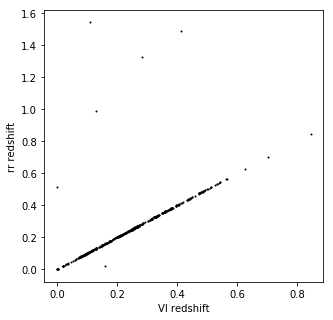

In [100]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

pl.plot(truth['VI z'], truth['Redrock z'], marker='.', lw=0.0, c='k', markersize=2)

pl.xlabel('VI redshift')
pl.ylabel('rr redshift')

len(truth['VI z'])

----  20200227  ----
0 	 500 	 500
3 	 500 	 1000
6 	 500 	 1500
7 	 500 	 2000
9 	 500 	 2500
			0


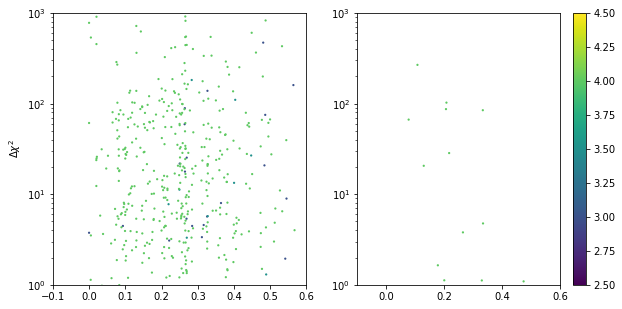

In [132]:
tile             = '70502'

fig, axes        = plt.subplots(1, 2, figsize=(10, 5))

for i, night in enumerate(['20200227']):
  print('----  {}  ----'.format(night))  

  total          =      0

  all_zbest      = Table()
    
    
  for petal in [0,3,6,7,9]:
    root         = '/global/cfs/cdirs/desi/spectro/redux/minisv2/tiles/'
    zbest        = Table(fits.open(root + '{}/{}/zbest-{}-{}-{}.fits'.format(tile, night, petal, tile, night))[1].data)
    
    all_zbest    = vstack((all_zbest, zbest))
    
    print('{} \t {} \t {}'.format(petal, len(zbest), len(all_zbest)))
    
  isin         = np.isin(all_zbest['TARGETID'], truth['TargetID'])
  isint        = np.isin(truth['TargetID'], all_zbest['TARGETID'])
     
  truez        = truth['VI z'][isint]
  vi_flag      = truth['vi_combined_flag'][isint].astype(np.float)
    
  dv           = 3.e5 * np.abs(all_zbest['Z'][isin] - truez) / (1. + truez)
  dv           = dv > 1000.
  
  sc = axes[0].scatter(truez[dv], all_zbest['DELTACHI2'][isin][dv], lw=0.0, marker='.', s=20, c=vi_flag[dv], vmin=2.5, vmax=4.5) 
  axes[0].set_xlim(-0.1, 0.6)
  axes[0].set_ylim(1.0, 1.e3)
  axes[0].set_yscale('log')  
  axes[0].set_ylabel(r'$\Delta \chi^2$')
    
  sc = axes[1].scatter(truez[~dv], all_zbest['DELTACHI2'][isin][~dv], lw=0.0, marker='.', s=20, c=vi_flag[~dv], vmin=2.5, vmax=4.5) 
  axes[1].set_xlim(-0.1, 0.6)
  axes[1].set_ylim(1.0, 1.e3)
  axes[1].set_yscale('log') 

  plt.colorbar(sc)
    
  print('\t\t\t{}'.format(total))

In [13]:
# _ = pl.hist(truth['VI z'], bins=np.arange(0.0, 1.1, 0.025))
# pl.xlabel('VI z')

In [45]:
# Matching
def matches(bgs_acoadds, bgs_azbests, spec, _RA='RA', _DEC='DEC'):
  c              = SkyCoord(ra=bgs_acoadds['TARGET_RA']*u.degree, dec=bgs_acoadds['TARGET_DEC']*u.degree)
  catalog        = SkyCoord(ra=spec[_RA]*u.degree, dec=spec[_DEC]*u.degree)

  idx, d2d, d3d  = c.match_to_catalog_sky(catalog)

  max_sep        = 1.0 * u.arcsec

  sep_constraint = d2d < max_sep

  c              = c[sep_constraint]

  _matches       = catalog[idx[sep_constraint]]

  coadd_matches  = bgs_acoadds[sep_constraint]
  zbest_matches  = bgs_azbests[sep_constraint] 
  spec_matches   =    spec[idx[sep_constraint]]
    
  dv             = 3.e5 * (zbest_matches['Z'] - spec_matches['Z']) / (1. + spec_matches['Z'])
  cat_fail       = np.abs(dv) > 1000.  
  cat_failids    = zbest_matches['TARGETID'][cat_fail]
    
  return  coadd_matches, zbest_matches, spec_matches, cat_fail, cat_failids

In [46]:
root          = '/global/cfs/cdirs/desi/spectro/redux/minisv2/tiles/'

In [47]:
night_tiles   = [('20200225', 70502),
                 ('20200227', 70502),
                 ('20200228', 70500),
                 ('20200303', 70500)]

In [48]:
sample        = Table()
row           = Table()

In [116]:
plot          = False

acoadds       = Table()
azbests       = Table()
acoadds_paths = []

for night, tile in night_tiles:
  for petal in [0,3,6,7,9]: 
    specfile                  = root + '{}/{}/coadd-{}-{}-{}.fits'.format(tile, night, petal, tile, night)

    coadds                    = Table(fits.open(specfile)[1].data)
    zbest                     = Table(fits.open(root + '/{}/{}/zbest-{}-{}-{}.fits'.format(tile, night, petal, tile, night))[1].data)
    
    acoadds_paths.append(specfile)
    
    targetids                 = zbest['TARGETID']
    fibstatus                 = fitsio.read(specfile, ext=1)['FIBERSTATUS']
    
    # No fiber reach flags available.
    isgood                    = fibstatus == 0
            
    IS_SV0                    = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_GOOD_BGS               = IS_SV0 & isgood
    IS_MAIN                   = IS_GOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)
    
    # Exclude QSOs (lack of redshift precision for small scales).
    IS_ZGOOD_BGS              = IS_GOOD_BGS  & (zbest['ZWARN'] == 0) & (zbest['SPECTYPE'] == 'GALAXY') 
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS & (zbest['ZERR'] < 0.0005 * (1. + zbest['Z']))
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS & (zbest['Z'] <= 0.5)
    
    IS_ZGOOD_MAIN             = IS_ZGOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)

    coadds['NIGHT']           = [night] * len(coadds)
    coadds['TILEID']          = [tile] * len(coadds)
    
    zbest['NIGHT']            = [night] * len(coadds)
    zbest['TILEID']           = [tile] * len(coadds)

    acoadds                   = vstack((acoadds, coadds[IS_ZGOOD_BGS]))
    azbests                   = vstack((azbests,  zbest[IS_ZGOOD_BGS]))
    
gcoadd_matches,  gzbest_matches,  gspec_matches,   gcat_fail, gcat_failids  = matches(acoadds, azbests, GAMA['south'], _RA='RA',      _DEC='DEC')

sncoadd_matches, snzbest_matches, snspec_matches, sncat_fail, sncat_failids = matches(acoadds, azbests, SDSS['north'], _RA='PLUG_RA', _DEC='PLUG_DEC')
sscoadd_matches, sszbest_matches, ssspec_matches, sscat_fail, sscat_failids = matches(acoadds, azbests, SDSS['south'], _RA='PLUG_RA', _DEC='PLUG_DEC')

In [81]:
np.unique(sszbest_matches['ZWARN'], return_counts=True)

(<MaskedColumn dtype='int64' length=1>
 0, array([207]))

721

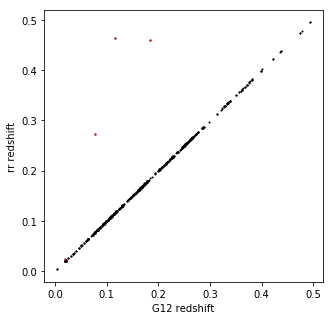

In [82]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

pl.plot(gspec_matches['Z'],            gzbest_matches['Z'], lw=0, marker='.', markersize=2, c='k')
pl.plot(gspec_matches['Z'][gcat_fail], gzbest_matches['Z'][gcat_fail], lw=0, marker='.', markersize=2, c='r')

pl.xlabel(r'G12 redshift')
pl.ylabel(r'rr redshift')

len(gspec_matches)

207

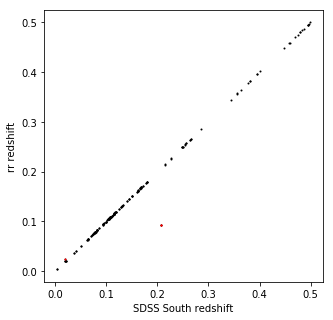

In [83]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

pl.plot(ssspec_matches['Z'],             sszbest_matches['Z'], lw=0, marker='.', markersize=2, c='k')
pl.plot(ssspec_matches['Z'][sscat_fail], sszbest_matches['Z'][sscat_fail], lw=0, marker='.', markersize=2, c='r')

pl.xlabel(r'SDSS South redshift')
pl.ylabel(r'rr redshift')

len(ssspec_matches)

174

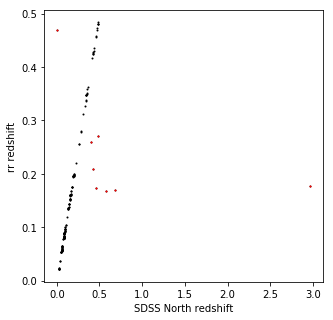

In [84]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

pl.plot(snspec_matches['Z'],             snzbest_matches['Z'], lw=0, marker='.', markersize=2, c='k')
pl.plot(snspec_matches['Z'][sncat_fail], snzbest_matches['Z'][sncat_fail], lw=0, marker='.', markersize=2, c='r')

pl.xlabel(r'SDSS North redshift')
pl.ylabel(r'rr redshift')

len(snspec_matches)

In [85]:
aszbest_matches = np.concatenate([sszbest_matches['Z'], snzbest_matches['Z']])
asspec_matches  = np.concatenate([ssspec_matches['Z'],  snspec_matches['Z']])

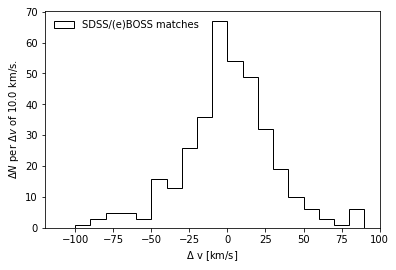

In [86]:
dv  = 3.e5 * (aszbest_matches - asspec_matches) / (1. + asspec_matches)

stp = 10.
_   = pl.hist(dv, bins=np.arange(-100., 100., stp), histtype='step', color='k', label='SDSS/(e)BOSS matches')

pl.xlim(-120., 100.)

pl.xlabel(r'$\Delta$ v [km/s]')
pl.ylabel(r'$\Delta N$ per $\Delta v$ of {} km/s.'.format(stp))

pl.legend(loc=2, frameon=False)

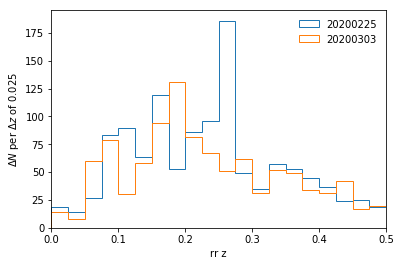

In [130]:
nights = list(np.unique(azbests['NIGHT']))

nights.remove('20200227')
nights.remove('20200228')

for night in nights:  
  _ = pl.hist(azbests['Z'][(azbests['NIGHT'] == night)], bins=np.arange(0.0, 1.2, 0.025), histtype='step', label=night)

pl.xlabel('rr z')
pl.ylabel(r'$\Delta N$ per $\Delta z$ of {}'.format(0.025))

pl.xlim(0.0, 0.5)

pl.legend(frameon=False, loc=1)

##  Prospect for the differences.

In [38]:
len(acoadds_paths)

20

In [67]:
fail_ids                      = np.concatenate([gcat_failids.data, sncat_failids.data, sscat_failids.data])
fail_ids                      = fail_ids.data
fail_ids

array([35185766787188134, 35185754724368479, 35185754745340561,
       35185730586151652, 35191204677158635, 35191204677160299,
       35191212587616629, 35191196670232919, 35191212583423743,
       35191220435160546, 35191204672966163, 35191204685546429,
       35185754749535144, 35185754745340561, 35185754749535144])

In [93]:
azbests[np.isin(azbests['TARGETID'].data, fail_ids)]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35185754724368479,11928.362674295902,1098.9938096537435 .. 38.11416777120257,0.18474233460771822,1.12565496150381e-05,0,7732,GALAXY,,10,2480.28952537477,0,0
35185766787188134,10239.828133173287,-53.71784865938137 .. 22.73593872007464,0.27333088724885773,4.538422529297212e-05,0,7746,GALAXY,,10,10.612046241760254,0,0
35185754745340561,10478.632955322042,1149.7414695127038 .. -22.351124104987488,0.020410460429866217,6.548514437804251e-06,0,7755,GALAXY,,10,1189.894606900365,0,0
35185754749535144,24538.739020109177,29267.912419386717 .. 1299.6770157662377,0.09354696691384304,6.409148657217593e-06,0,7749,GALAXY,,10,104608.92371099535,0,0
35185730586151652,10272.156889796257,1125.3077742731666 .. 49.320092412728386,0.11638065581870449,6.941500414945081e-06,0,7744,GALAXY,,10,2775.914508700371,0,0
35185754724368479,8804.233318284154,-697.6697325891325 .. -106.31587553057538,0.4594884377030813,4.392955278048388e-05,0,7729,GALAXY,,10,17.54369793832302,0,0
35185754745340561,8464.665983838902,1286.8593886776198 .. -9.249577611075122,0.025378924156213848,5.095259935963981e-05,0,7744,GALAXY,,10,9.86935939086834,0,0
35185754749535144,10192.58093899116,18194.63545618367 .. 971.3857372164686,0.09351834859281392,2.65757614406501e-05,0,7738,GALAXY,,10,6998.758367679082,0,0
35185730586151652,8779.78275193274,933.2324617326572 .. 31.926374139550603,0.4633665999222232,5.507481554351813e-05,0,7743,GALAXY,,10,14.441826459020376,0,0


In [105]:
for night, tile in night_tiles:
  for petal in [0,3,6,7,9]: 
    specfile                    = root + '{}/{}/coadd-{}-{}-{}.fits'.format(tile, night, petal, tile, night)

    zbest                       = Table(fits.open(root + '/{}/{}/zbest-{}-{}-{}.fits'.format(tile, night, petal, tile, night))[1].data)
    coadds                      = Table(fits.open(specfile)[1].data)
    
    spectra                     = desispec.io.read_spectra(specfile)
    spectra.fibermap["NIGHT"]   = np.ones(len(spectra.fibermap))
    
    targetids                   = zbest['TARGETID']
    fibstatus                   = fitsio.read(specfile, ext=1)['FIBERSTATUS']
    
    # No fiber reach flags available.
    isgood                      = fibstatus == 0
            
    IS_SV0                      = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_GOOD_BGS                 = IS_SV0 & isgood
    IS_MAIN                     = IS_GOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)
    
    # Exclude QSOs (lack of redshift precision for small scales).
    IS_ZGOOD_BGS                = IS_GOOD_BGS  & (zbest['ZWARN'] == 0) & (zbest['SPECTYPE'] == 'GALAXY') 
    IS_ZGOOD_BGS                = IS_ZGOOD_BGS & (zbest['ZERR'] < 0.0005 * (1. + zbest['Z']))
    IS_ZGOOD_BGS                = IS_ZGOOD_BGS & (zbest['Z'] <= 0.5)
     
    zbest                       =  zbest[IS_ZGOOD_BGS]
    coadds                      = coadds[IS_ZGOOD_BGS]
        
    gcoadd_matches,  gzbest_matches,  gspec_matches,   gcat_fail, gcat_failids  = matches(coadds, zbest, GAMA['south'], _RA='RA',      _DEC='DEC')

    sncoadd_matches, snzbest_matches, snspec_matches, sncat_fail, sncat_failids = matches(coadds, zbest, SDSS['north'], _RA='PLUG_RA', _DEC='PLUG_DEC')
    sscoadd_matches, sszbest_matches, ssspec_matches, sscat_fail, sscat_failids = matches(coadds, zbest, SDSS['south'], _RA='PLUG_RA', _DEC='PLUG_DEC')
        
    fail_ids                    = np.concatenate([gcat_failids.data, sncat_failids.data, sscat_failids.data])
        
    if len(fail_ids) > 0:        
      sp_single_exp             = spectra.select(targets=fail_ids)

      plotframes.plotspectra(sp_single_exp,\
                             zcatalog=zbest,\
                             notebook=False,\
                             with_coaddcam=False,\
                             with_thumb_tab=False,\
                             title='{}_{}_{}_known_catfails'.format(tile, night, petal),\
                             html_dir='/global/homes/m/mjwilson/www/MINISV')
    
      print('Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_{}_{}_{}_known_catfails.html'.format(tile, night, petal))
    
    else:
      print('No need to plot {} {} {}.'.format(tile, night, petal))

  _ = os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')

No need to plot 70502 20200225 0.
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70502_20200225_3_known_catfails.html
No need to plot 70502 20200225 6.
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70502_20200225_7_known_catfails.html
No need to plot 70502 20200225 9.
No need to plot 70502 20200227 0.
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70502_20200227_3_known_catfails.html
No need to plot 70502 20200227 6.
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70502_20200227_7_known_catfails.html
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70502_20200227_9_known_catfails.html
No need to plot 70500 20200228 0.
No need to plot 70500 20200228 3.
No need to plot 70500 20200228 6.
No need to plot 70500 20200228 7.
Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70500_20200228_9_known_catfai

##  Done.